In [155]:
import pickle
import plotly.express as px
from plotly.graph_objs import Figure
import pandas as pd

In [156]:
def create_figure(df, x_column, y_column) -> Figure:
    x_data = df[x_column]
    y_data = df[y_column]

    min_value = y_data.min()
    max_value = y_data.max()
    season_value = y_data.iloc[-1]
    
    fig = px.line(x=x_data, y=y_data, markers=True)
    fig.update_layout(
        xaxis_title=x_column,
        yaxis_title=y_column,
        title=f'{df['Name'].iloc[0]} {y_column} over time'
    )
    fig.add_hline(y=min_value, line_dash="dot", line_color="black", annotation_text=f'Min: {min_value}', annotation_position="bottom right")
    fig.add_hline(y=max_value, line_dash="dot", line_color="black", annotation_text=f'Max: {max_value}', annotation_position="top right")
    
    fig.add_annotation(text=f"End of Season Value {season_value}", x=x_data.iloc[-12], y=season_value-season_value*0.05, showarrow=False)
    
    fig.update_yaxes(nticks=20)
    return fig

In [157]:
player_dfs_2023 = pickle.load(open('2023_player_dfs.pkl', 'rb'))

In [158]:
player_dfs_2023.keys()

dict_keys([682928, 547989, 660670, 642715, 645277, 624413, 641313, 606115, 571448, 668227, 650333, 595879, 605137, 641355, 643217, 605141, 666182, 593428, 664761, 608324, 600869, 592192, 682998, 592206, 656305, 661388, 621043, 641487, 630105, 605204, 650559, 646240, 553869, 650490, 592273, 669242, 642731, 664034, 518692, 670770, 666969, 665926, 502671, 663757, 665489, 666971, 664023, 671739, 663647, 669720, 683002, 571771, 606192, 663538, 663697, 673962, 673490, 680757, 518934, 596019, 663993, 592518, 606466, 656716, 641857, 643446, 669004, 608841, 593160, 571970, 607043, 663457, 660271, 621566, 681546, 542303, 670623, 665161, 521692, 663728, 608070, 592663, 592669, 668804, 663586, 673357, 677594, 667670, 642708, 660688, 668939, 467793, 623993, 656941, 608369, 543760, 642086, 669257, 624585, 665742, 543807, 668715, 663886, 681082, 664702, 553993, 669261, 621020, 657041, 679529, 650402, 678662, 663656, 457759, 607208, 662139, 683734, 657077, 663837, 683011, 664774, 572233, 677951, 59288

In [159]:
player_dfs_2023[641355]

,Name,Age,#days,Lev,Date,Tm,G,PA,AB,R,...,OBP,SLG,OPS,mlbID,Day,wOBA,K%,BB%,ISO,wRC+
24,Cody Bellinger,27,311,Maj-NL,2023-03-30,Chicago,1,4,3,0,...,0.250,0.000,0.250,641355,0,0.172500,0.250000,0.250000,0.000000,-1.800000
28,Cody Bellinger,27,309,Maj-NL,2023-04-01,Chicago,2,8,7,0,...,0.125,0.000,0.125,641355,2,0.086250,0.375000,0.125000,0.000000,-8.700000
29,Cody Bellinger,27,308,Maj-NL,2023-04-02,Chicago,3,12,11,0,...,0.083,0.000,0.083,641355,3,0.057500,0.333333,0.083333,0.000000,-11.000000
29,Cody Bellinger,27,307,Maj-NL,2023-04-03,Chicago,4,17,15,1,...,0.177,0.267,0.443,641355,4,0.257059,0.235294,0.117647,0.200000,4.964706
30,Cody Bellinger,27,306,Maj-NL,2023-04-04,Chicago,5,23,20,2,...,0.304,0.350,0.654,641355,5,0.336087,0.173913,0.130435,0.150000,11.286957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,Cody Bellinger,27,131,Maj-NL,2023-09-26,Chicago,126,538,482,93,...,0.359,0.533,0.892,641355,180,0.472579,0.156134,0.072491,0.224066,22.206355
55,Cody Bellinger,27,130,Maj-NL,2023-09-27,Chicago,127,543,487,94,...,0.359,0.532,0.891,641355,181,0.471500,0.156538,0.071823,0.221766,22.120000
55,Cody Bellinger,27,129,Maj-NL,2023-09-28,Chicago,128,547,491,94,...,0.358,0.530,0.888,641355,182,0.469669,0.157221,0.071298,0.219959,21.973529
55,Cody Bellinger,27,128,Maj-NL,2023-09-29,Chicago,129,551,495,94,...,0.356,0.525,0.881,641355,183,0.466241,0.157895,0.070780,0.218182,21.699270


The below code computes stability off of when at a certain point a window gets below a standard deviation threshhold and a difference between the current value and the season mean. I worry that this is not a comprehensive way to measure stability since you could essentially get lucky by finding a temporarily stable period of time that is relatively close to the player's season value. 

Ideas to get around this:
* After you find the first window match (let's say at 65 games), compute how many "false" windows follow it (how many don't satisfy the threshold criteria). If the number of false windows is below another threshold, then keep the first window match, else move to the next one
* Create a measure of the std deviation rate of change - negative values means the value is getting more stable, then as it approaches 0 it's getting as stable as it will get

Will start by implementing the second option

In [178]:
def compute_league_variance(dfs:dict):
    """
    Compute the season stat variance of each stat across the league 
    """
    player_values = {}
    for key, df in dfs.items():
        player_values[key] = df.iloc[-1]
    
    return pd.DataFrame(player_values).T

In [179]:
df = compute_league_variance(player_dfs_2023)

In [180]:
df

,#days,2B,3B,AB,Age,BA,BB,BB%,CS,Date,...,RBI,SB,SF,SH,SLG,SO,Tm,mlbID,wOBA,wRC+
682928,126,28,6,563,22,0.245,32,0.052117,4,2023-10-01 00:00:00,...,64,47,3,3,0.412,118,Washington,682928,0.385556,15.244444
547989,126,23,1,540,36,0.237,42,0.070707,1,2023-10-01 00:00:00,...,90,0,6,0,0.383,130,Houston,547989,0.362833,13.426644
660670,126,35,4,643,25,0.338,80,0.108844,14,2023-10-01 00:00:00,...,106,72,3,0,0.596,84,Atlanta,660670,0.532473,26.997814
642715,126,29,2,553,27,0.217,71,0.111285,3,2023-10-01 00:00:00,...,80,5,6,0,0.407,165,Milwaukee,642715,0.392292,15.783359
645277,126,30,5,596,26,0.28,46,0.069697,1,2023-10-01 00:00:00,...,109,13,8,0,0.513,107,Atlanta,645277,0.456307,20.904559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665750,126,31,3,511,24,0.266,35,0.063177,4,2023-10-01 00:00:00,...,67,14,4,3,0.421,117,Texas,665750,0.396282,16.102527
673548,127,31,6,515,28,0.285,59,0.101201,7,2023-09-30 00:00:00,...,74,6,7,0,0.485,130,Chicago,673548,0.451724,20.537931
665487,126,33,1,575,24,0.257,53,0.083465,4,2023-10-01 00:00:00,...,78,29,3,1,0.449,141,San Diego,665487,0.419654,17.972283
672580,126,20,4,464,23,0.272,38,0.073786,7,2023-10-01 00:00:00,...,50,23,10,1,0.358,115,Kansas City,672580,0.34967,12.373592


In [171]:
def sliding_window_stability(dfs:dict, stat:str) -> dict:
    """
    Works by computing the standard deviation for a given stat over a sliding window of games
    so that we can see how a player's performance stabilizes over time
    """
    stability = {}
    window_size = 10 # games
    thresholds = {
        'OPS': {
            'std': 0.02,
            'std_roc': 0.004,
            'mean': 0.03
        },
        'K%': {
            'std': 0.02,
            'std_roc': 0.001,
            'mean': 0.01
        }
    }
    window_lag = 5
    lagged_std = 0
    log = []
    stability = pd.DataFrame(index=dfs.keys(), columns=[f'Season {stat}', f'Game Threshold {stat}', f'{stat} Mean', f'{stat} Std'])

    for player_id, df in dfs.items():
        i = 0
        stability.at[player_id,f'Season {stat}'] = df[stat].iloc[-1]
        stability.at[player_id,f'Game Threshold {stat}'] = df['G'].iloc[-1]
        stability.at[player_id,f'{stat} Mean'] = -1
        stability.at[player_id,f'{stat} Std'] = -1

        while i+window_size < len(df):
            window_stats = df.iloc[i:i+window_size][stat]
            window_std = window_stats.std()
            window_mean = window_stats.mean()
            mean_diff = abs(window_mean - stability.at[player_id,f'Season {stat}'])
            window_std_roc = abs(window_std - lagged_std)

            if player_id == 641355:
                log.append(f"Games: {i+window_size}, Window Mean: {round(window_mean,3)}, Window Std: {round(window_std,4)},\
                           Mean Diff: {round(mean_diff,3)}, Std ROC: {round(window_std_roc,4)}")

            if window_std < thresholds[stat]['std'] and mean_diff < thresholds[stat]['mean'] and window_std_roc < thresholds[stat]['std_roc']:
                stability.at[player_id, f'Game Threshold {stat}'] = i+window_size
                stability.at[player_id, f'{stat} Mean'] = window_mean
                stability.at[player_id, f'{stat} Std'] = window_std
                break
            i+=1
            # if i-window_lag > 0:
            lagged_window = df.iloc[i-window_lag:i-window_lag+window_size][stat]
            lagged_std = lagged_window.std()

    return stability, log

In [172]:
stability_OPS, log = sliding_window_stability(player_dfs_2023, 'OPS')
stability_K, log = sliding_window_stability(player_dfs_2023, 'K%')

In [173]:
stability_OPS

,Season OPS,Game Threshold OPS,OPS Mean,OPS Std
682928,0.712,54,0.6891,0.006919
547989,0.68,106,0.6529,0.007695
660670,1.012,29,1.006,0.019861
642715,0.717,85,0.6947,0.017004
645277,0.849,88,0.8256,0.012394
...,...,...,...,...
665750,0.733,97,0.7605,0.007649
673548,0.842,128,0.8197,0.007973
665487,0.771,38,0.7744,0.019045
672580,0.681,35,0.6888,0.017364


In [175]:
stability_OPS['Game Threshold OPS'].mean()

73.51127819548873

In [177]:
stability_K['Game Threshold K%'].mean()

68.9172932330827

In [150]:
player_key = 682928

In [151]:
stability_OPS[player_key]

{'Season OPS': 0.712,
 'Game Threshold OPS': 54,
 'OPS Mean': 0.6891,
 'OPS Std': 0.006919376979018936}

In [152]:
fig = create_figure(player_dfs_2023[player_key], x_column='G', y_column='OPS')
fig.add_vline(x=stability_OPS[player_key]['Game Threshold OPS'], line_dash="dot", line_color="black", annotation_text=f'OPS Stabilized (Est: {round(stability_OPS[player_key]['OPS Mean'],3)})', annotation_position="bottom right")
fig.show()

In [153]:
fig = create_figure(player_dfs_2023[player_key], x_column='G', y_column='K%')
fig.add_vline(x=stability_K[player_key]['Game Threshold K%'], line_dash="dot", line_color="black", annotation_text=f'K% Stabilized (Est: {round(stability_K[player_key]['K% Mean'],3)})', annotation_position="bottom right")
fig.show()

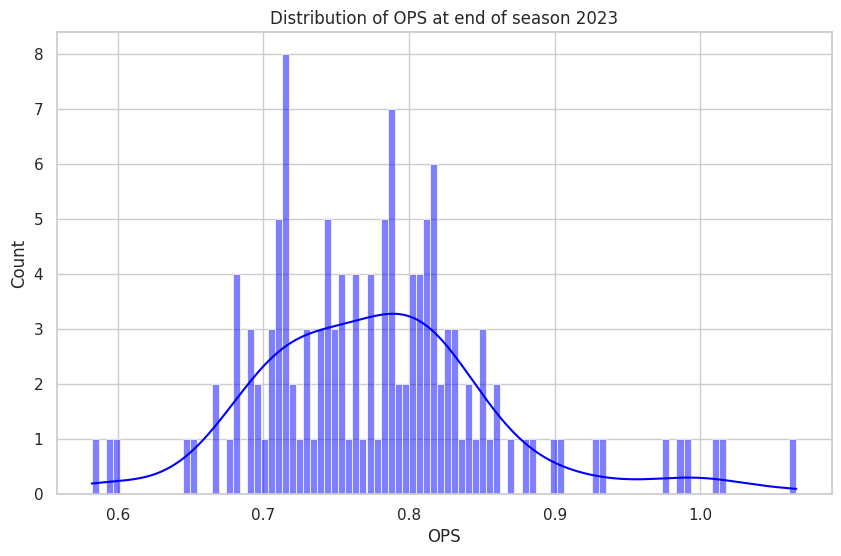

In [63]:
# Plot distribution of OPS for all players in player_dfs_2023
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

ops = [df['OPS'].iloc[-1] for df in player_dfs_2023.values()]
plt.figure(figsize=(10,6))
sns.histplot(ops, kde=True, bins=100, color='blue')
plt.title('Distribution of OPS at end of season 2023')
plt.xlabel('OPS')
plt.show()


In [ ]:
def compute_stability(dfs:dict, statistic:str) -> dict:
    """
    Computes the stability using different statisitcal techniques for all players
    """
    for key, df in dfs.items():
        print(f"Computing stability for {df['Name'].iloc[0]}")
        
        


    return